https://www.sighthound.com/products/cloud

5,000 API Calls (per month?) on developer tier

Note that bounding boxes are specified differently compared to clarifai etc

In [1]:
import requests
import os
import io
import base64
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import sys
print(sys.version)

ATTR_GENDER_CONFIDENCE = 'gender_confidence'
ATTR_PERSONS = 'persons'
ATTR_TOTAL_PERSONS = 'total_persons'
ATTR_AGE = 'age'
ATTR_CONFIDENCE = 'confidence'
ATTR_FACES = 'faces'
ATTR_GENDER = 'gender'
ATTR_GLASSES = 'glasses'
ATTR_MOTION = 'motion'
ATTR_TOTAL_FACES = 'total_faces'
ATTR_BOUNDING_BOX = 'bounding_box'
ATTR_IMAGE_ID = 'image_id'
ATTR_MATCHED = 'matched'
CLASSIFIER = 'facebox'
TIMEOUT = 9

def load_api_secrets(filename):
    """Convenience to load the API key from a json file."""
    try:
        with open(filename, 'r') as fp:
            api_params = json.load(fp)
    except Exception as e:
        print('Failed to load API secrets key: {}'.format(e))
        api_params = None
    return api_params['key']

    
def encode_image(image):
    """base64 encode an image stream."""
    base64_img = base64.b64encode(image).decode('ascii')
    return base64_img

def parse_api_response(response):
    """Parse the response from the API. """
    faces = []
    persons = []
    for obj in response.json()['objects']:
        if obj['type'] == 'face':
            faces.append(obj)
        if obj['type'] == 'person':
            persons.append(obj)
    return faces, persons

def parse_faces(api_faces):
    """Parse the API face data into the format required."""
    known_faces = []
    for entry in api_faces:
        face = {}
        face[ATTR_GENDER] = entry['attributes']['gender']
        face[ATTR_GENDER_CONFIDENCE] = round(100.0*entry['attributes']['genderConfidence'], 2)
        face[ATTR_BOUNDING_BOX] = entry['boundingBox']
        known_faces.append(face)
    return known_faces

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
api_key_file_path = '/Users/robin/Documents/Sighthound_API_key.json'
api_key = load_api_secrets(api_key_file_path)

In [3]:
headers = {"Content-type": "application/json",
           "X-Access-Token": api_key}

In [5]:
image_file_path = 'people.jpg'

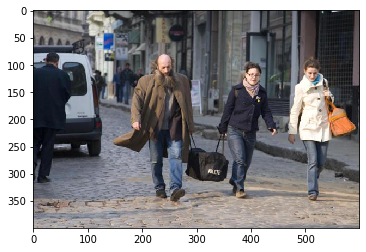

In [6]:
img = plt.imread(image_file_path)  # Creates an ndarray
plt.imshow(img)
plt.show()

In [7]:
with open(image_file_path, "rb") as img_bytes:
    image_data = encode_image(img_bytes.read()) 

In [8]:
url = 'https://dev.sighthoundapi.com/v1/detections'

In [9]:
params = (
    ('type', 'face,person'),
    ('faceOption', 'gender'),
)


In [10]:
%%time
response = requests.post('https://dev.sighthoundapi.com/v1/detections', 
                         headers=headers, 
                         params=params, 
                         data=json.dumps({"image": image_data}))

CPU times: user 25.3 ms, sys: 6.81 ms, total: 32.1 ms
Wall time: 993 ms


In [11]:
assert response.status_code == 200

In [12]:
response.json()

{'image': {'width': 600, 'height': 400, 'orientation': 1},
 'objects': [{'type': 'face',
   'boundingBox': {'x': 387, 'y': 105, 'height': 34, 'width': 30},
   'attributes': {'gender': 'male',
    'genderConfidence': 0.8047,
    'frontal': True}},
  {'type': 'face',
   'boundingBox': {'x': 498, 'y': 101, 'height': 34, 'width': 27},
   'attributes': {'gender': 'male',
    'genderConfidence': 0.9699,
    'frontal': True}},
  {'type': 'face',
   'boundingBox': {'x': 230, 'y': 89, 'height': 34, 'width': 31},
   'attributes': {'gender': 'male',
    'genderConfidence': 0.9358,
    'frontal': True}},
  {'type': 'person',
   'boundingBox': {'x': 336, 'y': 99, 'height': 251, 'width': 115}},
  {'type': 'person',
   'boundingBox': {'x': 180, 'y': 73, 'height': 279, 'width': 116}},
  {'type': 'person',
   'boundingBox': {'x': 468, 'y': 90, 'height': 272, 'width': 98}},
  {'type': 'person',
   'boundingBox': {'x': 4, 'y': 78, 'height': 224, 'width': 76}}],
 'requestId': '0aeb9b48073b46f0b546220f4384

In [13]:
len(response.json()['objects'])

7

In [14]:
persons = []
faces = []

for obj in response.json()['objects']:
    print(obj['type'])
    if obj['type'] == 'person':
        persons.append(obj)    
    if obj['type'] == 'face':
        faces.append(obj)

face
face
face
person
person
person
person


In [15]:
len(faces)

3

In [16]:
len(persons)

4

In [17]:
persons[0]

{'type': 'person',
 'boundingBox': {'x': 336, 'y': 99, 'height': 251, 'width': 115}}

In [18]:
bounding_box  = response.json()['objects'][0]['boundingBox']
bounding_box

{'x': 387, 'y': 105, 'height': 34, 'width': 30}

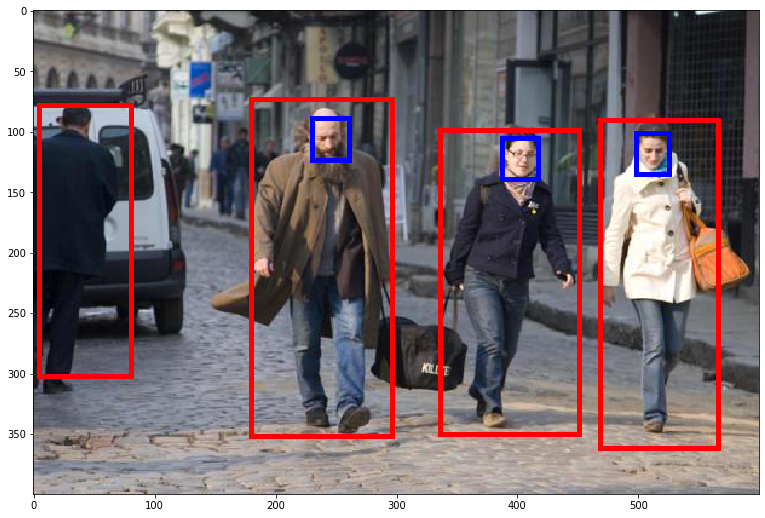

In [19]:
fig,ax = plt.subplots(1, figsize = (13, 18))

# Display the image
ax.imshow(img)

for i, obj in enumerate(response.json()['objects']):
    bounding_box = response.json()['objects'][i]['boundingBox']
    x_orig = bounding_box['x']
    y_orig = bounding_box['y']
    width = bounding_box['width']
    height = bounding_box['height']
    
    if obj['type'] == 'person':
        rect = patches.Rectangle((x_orig,y_orig),width,height,linewidth=5,edgecolor='r',facecolor='none')

    elif obj['type'] == 'face':
        rect = patches.Rectangle((x_orig,y_orig),width,height,linewidth=5,edgecolor='b',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()